In [1]:
from rdflib import URIRef, Literal
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import pandas as pd
from pprint import pprint
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
graph = RDFGraph()
graph.parse('./data/imdb-1m.ttl', format="turtle")

<Graph identifier=Nf6a20f36a0c94b20852477f5516e69d7 (<class 'rdflib.graph.Graph'>)>

In [3]:
all_people = graph.query("""
SELECT ?actor
WHERE {
    ?actor a schema:Person .
}
""")

In [4]:
print(len(all_people))

114821


In [5]:
all_movies = graph.query("""
SELECT ?movie
WHERE {
    ?movie a schema:Movie
}
""")

In [6]:
print(f"Found {len(all_movies)} movies, {len(all_movies)/40}% of original dataset")

Found 3839 movies, 95.975% of original dataset


In [7]:
all_actors = graph.query("""
SELECT ?actor (count(?actor) as ?count)
WHERE {
    ?movie a schema:Movie .
    ?movie schema:Actor ?actor
}
GROUP BY ?actor
""")

In [8]:
len(all_actors)

100321

{1: 75164,
 2: 12537,
 3: 4942,
 4: 2611,
 5: 1470,
 6: 948,
 7: 677,
 8: 438,
 9: 353,
 10: 234,
 11: 214,
 12: 159,
 13: 118,
 14: 79,
 15: 70,
 16: 73,
 17: 49,
 18: 45,
 19: 32,
 20: 22,
 21: 13,
 22: 6,
 23: 12,
 24: 10,
 25: 8,
 26: 9,
 27: 3,
 28: 3,
 29: 2,
 30: 1,
 31: 3,
 32: 2,
 33: 2,
 34: 4,
 35: 1,
 40: 1,
 41: 2,
 45: 1,
 51: 1,
 53: 1,
 60: 1}


<AxesSubplot:>

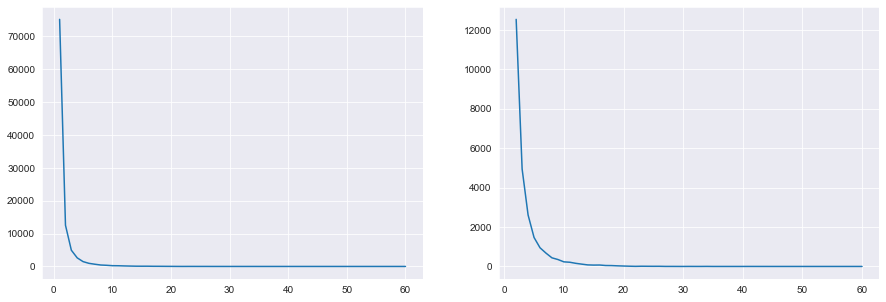

In [9]:
actor_movies_count = {}
for uri, movies in all_actors:
    if int(movies) not in actor_movies_count.keys():
        actor_movies_count[int(movies)] = 1
    else:
        actor_movies_count[int(movies)] += 1
pprint(actor_movies_count)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.lineplot(data=actor_movies_count, ax=ax[0])
actor_movies_count.pop(1)
sns.lineplot(data=actor_movies_count, ax=ax[1])


In [10]:
movies_with_actors = graph.query("""
SELECT ?movie (count(?actor) as ?count)
WHERE {
    ?movie a schema:Movie .
    ?movie schema:Actor ?actor
}
GROUP BY ?movie
""")

In [11]:
movies_by_actor = {}
for movie, actors in movies_with_actors:
    if int(actors) > 300:
        print(f"{movie}: {actors}")
        continue
    if int(actors) not in movies_by_actor.keys():
        movies_by_actor[int(actors)] = 1
    else:
        movies_by_actor[int(actors)] += 1

print(f"Removing {movies_by_actor.pop(1)} movies with 1 actor.")
for movie, actors in movies_with_actors:
    if int(actors) > 300 or int(actors) == 1:
        if movie in movies_by_actor.keys():
            movies_by_actor.pop(movie)


https://www.imdb.com/title/tt0048960: 1304
https://www.imdb.com/title/tt0051994: 365
https://www.imdb.com/title/tt0104797: 354
Removing 83 movies with 1 actor.


<AxesSubplot:ylabel='Count'>

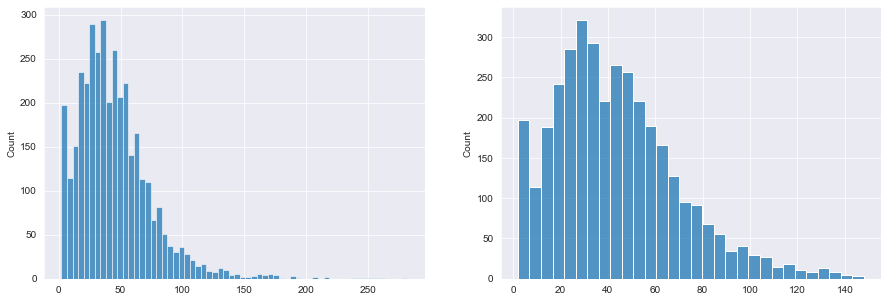

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=[key for key, val in movies_by_actor.items() for _ in range(val)], ax=ax[0])
sns.histplot(data=[key for key, val in movies_by_actor.items() for _ in range(val) if key < 150], bins=30, ax=ax[1])

In [18]:
actor_df = pd.DataFrame(
    dtype=pd.SparseDtype(), columns=[m for m, a in movies_with_actors if 2 < int(a) < 300],
    index=[a for a, m in all_actors if int(m) > 5]
)
actor_dft = actor_df.transpose()
actor_dft.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3573 entries, https://www.imdb.com/title/tt0010418 to https://www.imdb.com/title/tt9853992
Columns: 3597 entries, https://www.imdb.com/name/nm0000036 to https://www.imdb.com/name/nm7466455
dtypes: Sparse[float64, nan](3597)
memory usage: 27.9+ KB


In [19]:
df = actor_df.dot(actor_dft).astype(pd.SparseDtype())

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3597 entries, https://www.imdb.com/name/nm0000036 to https://www.imdb.com/name/nm7466455
Columns: 3597 entries, https://www.imdb.com/name/nm0000036 to https://www.imdb.com/name/nm7466455
dtypes: Sparse[float64, nan](3597)
memory usage: 157.1+ KB


In [21]:
g_movies = nx.from_pandas_adjacency(df)

In [23]:
nx.write_graphml(g_movies, './data/actor_adjacency.graphml')